<h1> House Price Prediction Challenge</h1>
<h5> By Franke van der Vorm and Bart van Moorsel</h5>

<p> Project House Price Prediction Challenge (HPPC) is a 4-day assignment given by Avans Hogeschool in the Data Science for the Smart Industry minor on 31/10/2022. The original challenge can be found on <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques">Kaggle</a>. The purpose of this challenge is to test the students ability to successfully make predictions based on historical data and evaluate the results. The given case of this challenge is to prediction house prices based on an unprepared dataset of around 80 columns and 1460 rows. This dataset can be found <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data">here</a>. </p>

<p> This markdown is intended for demonstrating the solution made by the HPPC-team. On this page, every collection of cells will be described in a way that explains what has been done and why it has been done. The solution is structured in 4 sections:

*   Importing the right modules
*   Pre-processing the data
*   Training the linear regression model
*   Evaluating the model</p>

<p> The chosen model for this assignment is a linear regression model. This model has been chosen because the target value is of numerical type, namely the price at which a house will be sold. In combination with an X amount of feature variables makes this a good option for linear regression.</p>

<h3> Importing the right modules </h3>
<p> Pandas and Numpy are used for efficient data manipulation. The machine learning module will be SKLearn, this will be used for fitting and evaluating the model. Lastly, matplotlib will be utilized for visualising the results. Next, the dataset will be loaded in and inspected. </p>

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv", index_col=0)
print(df)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea

<h3> Pre-processing the data </h3>
<p> As mentioned before, the dataset is unprepared and not ready for fitting. This means that data will have to be pre-processed first. This requires a significant understanding of the data. The data-understanding of the HCCP team is documented in the <a href="">data-understanding report</a>, which also describes how certain data is filtered. </p>

<p> The raw data could be categorized in two categories; numerical data and categorical data. Both need a different approach. If there are no missing values for a categorical column, then it is ready for one-hot-encoding. In this coding section, the columns judged not to be worth it will be dropped first. Secondly, the numerical columns will be processed.</p>

In [2]:
# Pre-process data
X_final = pd.DataFrame()

# Drop columns
df = df.drop('Fence', axis=1)  
df = df.drop('Alley', axis=1)  
df = df.drop('PoolQC', axis=1)
df = df.drop('MiscFeature', axis=1)
df = df.drop('FireplaceQu', axis=1)

# Replace null values
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())
df["MasVnrArea"] = df["MasVnrArea"].fillna(df["MasVnrArea"].mean())
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(2001)

df['BsmtExposure'] = df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])
df['BsmtQual'] = df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
df['BsmtCond'] = df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])

df['GarageCond'] = df['GarageCond'].fillna(df['GarageCond'].mode()[0])
df['GarageQual'] = df['GarageQual'].fillna(df['GarageQual'].mode()[0])
df['GarageType'] = df['GarageType'].fillna(df['GarageType'].mode()[0])
df['GarageFinish'] = df['GarageFinish'].fillna(df['GarageFinish'].mode()[0])

df['BsmtFinType1'] = df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0])
df['BsmtFinType2'] = df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])

df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])

# Remove rows with outliers
drop_index = df[(df["SalePrice"] < 200000) & (df["OverallQual"] > 8) & (df["GrLivArea"] > 4000)].index
df = df.drop(drop_index, axis = 0)

<p> MSSubClass will by default be recognized as a numerical column as it exists out of numbers, however, the numbers represent categories and thus should not be considered as a linear feature. Therefore, it will be formatted as a string.</p>

In [3]:
# Prepare data for one hot encoding
df["MSSubClass"] = list(map(lambda sub_class: "MS_" + str(sub_class) , df["MSSubClass"])) # Remap sub_class to strings for one hot encoding

# Separate feature and target data
y = df["SalePrice"].values
df = df.drop('SalePrice', axis=1)

<p> In this section, one hot encoding will be applied to all columns of type string. The resulting one hot encoded data will be joined with the processed data, X_final. </p>

In [4]:
# Do one hot encoding for every string column
for column in df.columns:
    selected_column = df[[column]]
    c_type = type(selected_column.iloc[0, 0])

    if c_type == str:
        ohe_df = pd.get_dummies(selected_column, prefix=column, drop_first=True)
        X_final = ohe_df.join(X_final)
    elif c_type == np.int16 or c_type == np.int32 or c_type == np.int64 or c_type == np.float16 or c_type == np.float32 or c_type == np.float64:
        X_final = selected_column.join(X_final)
    else:
        raise ValueError

X = X_final.values

<h3> Training the linear regression model </h3>

<p> Now that the data is clean, it can be used for training the model. Training and test data will be split by the train_test_split method from sklearn. The training ratio will be 75% 25%. After splitting, a linear regression model will be trained on the training data.</p>

In [5]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Train LinearRegression model
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

<h3> Evaluating the model </h3>

<p> To determine if the model is valid, it will have to be evaluated. This will be done by calculating the mean squared error and by a 10-fold cross validation. Additionally, a root squared score is calculated to compare against the 10-fold cross validation.
</p>

In [6]:
# Evaluate results
kf = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(reg, X, y, cv=kf)
cv_mean = np.mean(cv_scores)

y_pred = reg.predict(X_test)
r_squared = reg.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Root squared score: " + str(r_squared))
print("Mean squared error: " + str(rmse))
print("Scores 10-fold CV: " + str(cv_scores))
print("Mean 10-fold CV: " + str(cv_mean))

Root squared score: 0.904294537443414
Mean squared error: 28055.007424837146
Scores 10-fold CV: [0.9216988  0.9153235  0.91751102 0.89365311 0.88247987 0.91146445
 0.87583702 0.90650775 0.84409115 0.89923684]
Mean 10-fold CV: 0.8967803499470752


<p> To interpret if a model has been getting worse or better, it must be compared with its history. This coding section makes a history dataframe containing the attempt number and the previously mentioned mean_cv and mean squared error. If there already exists such dataframe locally, it will be loaded in, if not, it will be made. </p>

In [7]:
# Before evaluating on history, retrieve the history
history = pd.DataFrame(columns=["Attempt", "mean_cv", "rmse"] );
try:
    history = pd.read_csv("history.csv")
    print("Found history.csv with rows amount: " + str(history.shape[0]))
except FileNotFoundError:
    print("history.csv not found, creating new one")
    history.to_csv('history.csv', index = False)


Found history.csv with rows amount: 205


<p> After the results get saved to history.csv, the history and the results will be displayed in a plot made with matplotlib. The plot shows an indication of progress and cross validation score but should not be taken too literally as the model could have been ran multiple times without changes or as the cross validation score has been calculated differently at certain attempts. The purpose is to see how certain changes affect the performance of the model. </p>

     Attempt   mean_cv     rmse
201    201.0  0.897530  23216.0
202    202.0  0.892427  28409.0
203    203.0  0.895499  26698.0
204    204.0  0.895873  25759.0

Current attempt: 
      Attempt  mean_cv     rmse
205    205.0  0.89678  28055.0


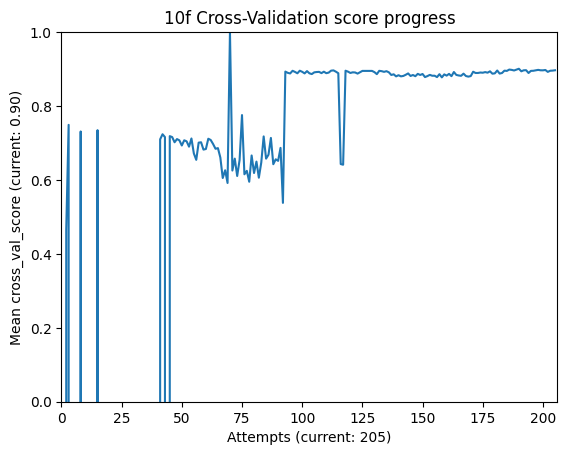

In [8]:
# Evaluate based on history and visualize progress
current_attempt = int(len(history.index))
history.loc[len(history.index)] = [current_attempt, cv_mean, int(rmse)]
print(history[-5:-1])
print()
print("Current attempt: \n", history.iloc[-1:])
history.to_csv('history.csv', index = False)

plt.plot(history["Attempt"], history["mean_cv"])

plt.xlabel("Attempts (current: {:.0f}".format(current_attempt) + ")")
plt.xlim(0, np.size(history["Attempt"].values))
plt.ylabel("Mean cross_val_score (current: {:.2f}".format(cv_mean) + ")")
plt.ylim(0, 1)
plt.title("10f Cross-Validation score progress")
plt.show()
